# Vibe Matcher: Mini Recommender Prototype

AI can augment Nexora's product discovery by matching a shopper's vibe (free-text intent) to items whose descriptions and style tags semantically align. This notebook builds a compact pipeline: mock catalog → OpenAI embeddings → cosine similarity search → quick evaluation and latency plot. It’s intentionally small, explainable, and fast to iterate, yet extensible to vector DBs and better re-ranking later.

---

## Sections
1. Setup
2. Data Prep
3. Embeddings
4. Vector Search
5. Test & Eval
6. Metrics & Plot
7. Reflection


In [ ]:
# Setup
!pip -q install openai pandas numpy scikit-learn matplotlib python-dotenv tenacity

import os, time, json
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tenacity import retry, wait_exponential, stop_after_attempt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Optional: Hardcode your API key here (leave empty to use TF-IDF fallback)
HARDCODED_OPENAI_API_KEY = ""
try:
    from openai import OpenAI
    if HARDCODED_OPENAI_API_KEY:
        client = OpenAI(api_key=HARDCODED_OPENAI_API_KEY)
    else:
        client = OpenAI()
except Exception:
    client = None
    import openai  # legacy fallback

# Resolve API key preference: hardcoded > env
OPENAI_API_KEY = HARDCODED_OPENAI_API_KEY or os.getenv("OPENAI_API_KEY")

# Configure legacy SDK if used
if OPENAI_API_KEY:
    try:
        import openai as _openai_legacy
        _openai_legacy.api_key = OPENAI_API_KEY
    except Exception:
        pass

if not OPENAI_API_KEY:
    print("OPENAI_API_KEY not set — will fall back to local TF-IDF embeddings.")


In [2]:
# Data Prep: mock catalog (5–10 items)

@dataclass
class Product:
    name: str
    vibes: List[str]
    price: float
    desc: str

def build_catalog() -> List[Product]:
    return [
        Product("Boho Festival Dress", ["boho","cozy","festival","earthy"], 89.99,
                "Flowy, earthy tones, relaxed silhouette for outdoor festivals."),
        Product("Urban Sleek Blazer", ["urban","professional","minimalist","edgy"], 159.99,
                "Tailored city blazer with sharp lines for modern professionals."),
        Product("Vintage Leather Jacket", ["edgy","vintage","rebellious","cool"], 249.99,
                "Classic leather with worn-in finish; bold and timeless."),
        Product("Cozy Oversized Sweater", ["cozy","comfort","casual","warm"], 74.99,
                "Soft oversized knit for lounging and everyday comfort."),
        Product("Neon Cyber Bodysuit", ["energetic","urban","futuristic","bold"], 129.99,
                "High-impact neon accents; nightlife-ready futuristic vibe."),
        Product("Romantic Lace Gown", ["romantic","elegant","sophisticated","feminine"], 349.99,
                "Graceful lace detailing for formal occasions."),
        Product("Eco-Conscious Linen Pants", ["sustainable","minimal","eco","conscious"], 94.99,
                "Breathable linen, ethically produced with sustainable materials."),
        Product("Glam Sequin Tank", ["glam","party","sparkly","celebratory"], 64.99,
                "Shimmering sequins for party looks."),
        Product("Sporty Athleisure Set", ["sporty","active","casual","confident"], 119.99,
                "Performance fabric for gym-to-street versatility."),
        Product("Avant-Garde Experimental Jacket", ["experimental","artistic","bold","creative"], 299.99,
                "Sculptural statement piece with unconventional design."),
    ]

products = build_catalog()

def product_text(p: Product) -> str:
    return " ".join([p.name, " ".join(p.vibes), p.desc])

df = pd.DataFrame([
    {"name": p.name, "vibes": p.vibes, "price": p.price, "desc": p.desc, "text": product_text(p)}
    for p in products
])

df


,name,vibes,price,desc,text
0,Boho Festival Dress,"[boho, cozy, festival, earthy]",89.99,"Flowy, earthy tones, relaxed silhouette for ou...",Boho Festival Dress boho cozy festival earthy ...
1,Urban Sleek Blazer,"[urban, professional, minimalist, edgy]",159.99,Tailored city blazer with sharp lines for mode...,Urban Sleek Blazer urban professional minimali...
2,Vintage Leather Jacket,"[edgy, vintage, rebellious, cool]",249.99,Classic leather with worn-in finish; bold and ...,Vintage Leather Jacket edgy vintage rebellious...
3,Cozy Oversized Sweater,"[cozy, comfort, casual, warm]",74.99,Soft oversized knit for lounging and everyday ...,Cozy Oversized Sweater cozy comfort casual war...
4,Neon Cyber Bodysuit,"[energetic, urban, futuristic, bold]",129.99,High-impact neon accents; nightlife-ready futu...,Neon Cyber Bodysuit energetic urban futuristic...
5,Romantic Lace Gown,"[romantic, elegant, sophisticated, feminine]",349.99,Graceful lace detailing for formal occasions.,Romantic Lace Gown romantic elegant sophistica...
6,Eco-Conscious Linen Pants,"[sustainable, minimal, eco, conscious]",94.99,"Breathable linen, ethically produced with sust...",Eco-Conscious Linen Pants sustainable minimal ...
7,Glam Sequin Tank,"[glam, party, sparkly, celebratory]",64.99,Shimmering sequins for party looks.,Glam Sequin Tank glam party sparkly celebrator...
8,Sporty Athleisure Set,"[sporty, active, casual, confident]",119.99,Performance fabric for gym-to-street versatility.,Sporty Athleisure Set sporty active casual con...
9,Avant-Garde Experimental Jacket,"[experimental, artistic, bold, creative]",299.99,Sculptural statement piece with unconventional...,Avant-Garde Experimental Jacket experimental a...


In [3]:
# Embeddings: OpenAI (text-embedding-3-small by default) with TF-IDF fallback
EMBED_MODEL = os.getenv("EMBED_MODEL", "text-embedding-3-small")  # or "text-embedding-ada-002"

EMBED_BACKEND = "openai" if (OPENAI_API_KEY or client is not None) else "tfidf"
_vectorizer = None  # for TF-IDF backend


def _embed_batch_openai(texts: List[str]) -> List[List[float]]:
    if client is not None:
        resp = client.embeddings.create(model=EMBED_MODEL, input=texts)
        return [d.embedding for d in resp.data]
    else:
        import openai
        openai.api_key = OPENAI_API_KEY
        resp = openai.Embedding.create(model=EMBED_MODEL, input=texts)
        return [d["embedding"] for d in resp["data"]]


def _embed_texts_tfidf(texts: List[str]) -> List[List[float]]:
    # Uses the fitted global _vectorizer
    mats = _vectorizer.transform(texts)
    return [row.toarray().ravel().tolist() for row in mats]


@retry(wait=wait_exponential(multiplier=1, min=1, max=20), stop=stop_after_attempt(5))
def embed_texts(texts: List[str], batch_size: int = 64) -> List[List[float]]:
    if EMBED_BACKEND == "openai":
        out: List[List[float]] = []
        for i in range(0, len(texts), batch_size):
            out.extend(_embed_batch_openai(texts[i:i+batch_size]))
        return out
    else:
        return _embed_texts_tfidf(texts)

print(f"Embedding backend: {EMBED_BACKEND}")
print("Embedding products...")

if EMBED_BACKEND == "openai":
    prod_embeddings = embed_texts(df["text"].tolist())
    emb_dim = len(prod_embeddings[0]) if prod_embeddings else 0
    print(f"\u2713 Embedded {len(prod_embeddings)} products | dim={emb_dim}")
    prod_matrix = np.array(prod_embeddings, dtype=np.float32)
else:
    # Fit TF-IDF on product texts
    _vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
    prod_matrix = _vectorizer.fit_transform(df["text"].tolist())
    emb_dim = prod_matrix.shape[1]
    print(f"\u2713 Built TF-IDF embeddings for {prod_matrix.shape[0]} products | dim={emb_dim}")

prod_matrix.shape


Embedding backend: openai
Embedding products...
✓ Embedded 10 products | dim=1536


(10, 1536)

In [4]:
# Vector Search: cosine top-3 with fallback

def search(query: str, top_k: int = 3, no_match_threshold: float = 0.15) -> Dict[str, Any]:
    q_emb = np.array(embed_texts([query])[0], dtype=np.float32)[None, :]
    sims = cosine_similarity(q_emb, prod_matrix)[0]
    idx = np.argsort(-sims)[:top_k]
    results = []
    for rank, i in enumerate(idx, start=1):
        row = df.iloc[i]
        results.append({
            "rank": rank,
            "name": row["name"],
            "price": float(row["price"]),
            "vibes": row["vibes"],
            "similarity": float(sims[i]),
        })
    max_sim = float(sims[idx[0]]) if len(idx) else 0.0
    fallback = None
    if max_sim < no_match_threshold:
        fallback = ("No strong matches found. Refine with 2–4 vibes (e.g., 'minimalist, eco'), "
                    "an occasion ('work', 'festival'), or fit preference.")
    return {"query": query, "results": results, "max_similarity": max_sim, "fallback": fallback}

# Demo query
_demo = search("futuristic urban party outfit", top_k=3)
_demo


{'query': 'futuristic urban party outfit',
 'results': [{'rank': 1,
   'name': 'Neon Cyber Bodysuit',
   'price': 129.99,
   'vibes': ['energetic', 'urban', 'futuristic', 'bold'],
   'similarity': 0.6334733963012695},
  {'rank': 2,
   'name': 'Urban Sleek Blazer',
   'price': 159.99,
   'vibes': ['urban', 'professional', 'minimalist', 'edgy'],
   'similarity': 0.4306928813457489},
  {'rank': 3,
   'name': 'Glam Sequin Tank',
   'price': 64.99,
   'vibes': ['glam', 'party', 'sparkly', 'celebratory'],
   'similarity': 0.4275652766227722}],
 'max_similarity': 0.6334733963012695,
 'fallback': None}

In [5]:
# Pretty print helper with bands

def band(score: float) -> str:
    return "HIGH" if score >= 0.7 else ("MODERATE" if score >= 0.5 else "LOW")

def print_results(result: Dict[str, Any]) -> None:
    print(result["query"]) 
    print("-" * 70)
    for r in result["results"]:
        print(f"  #{r['rank']} {r['name']} (${r['price']})")
        print(f"      Similarity: {r['similarity']:.4f} | {band(r['similarity'])}")
        print(f"      Vibes: {', '.join(r['vibes'])}")
    if result["fallback"]:
        print(f"  Fallback: {result['fallback']}")
    print()

print_results(_demo)


futuristic urban party outfit
----------------------------------------------------------------------
  #1 Neon Cyber Bodysuit ($129.99)
      Similarity: 0.6335 | MODERATE
      Vibes: energetic, urban, futuristic, bold
  #2 Urban Sleek Blazer ($159.99)
      Similarity: 0.4307 | LOW
      Vibes: urban, professional, minimalist, edgy
  #3 Glam Sequin Tank ($64.99)
      Similarity: 0.4276 | LOW
      Vibes: glam, party, sparkly, celebratory



In [6]:
# Test & Eval: 3 queries, metrics and timings

test_queries = [
    "I want bold, energetic urban nightlife fashion",
    "Looking for cozy, comfortable everyday wear",
    "Seeking sustainable, eco-conscious ethical fashion",
]

good_threshold = 0.7
latencies = []
records = []

for i, q in enumerate(test_queries, start=1):
    t0 = time.perf_counter()
    out = search(q, top_k=3)
    t1 = time.perf_counter()
    lat = t1 - t0
    latencies.append(lat)

    print_results(out)

    scores = [r["similarity"] for r in out["results"]]
    top1 = scores[0] if scores else 0.0
    avg_top3 = float(np.mean(scores)) if scores else 0.0
    quality = "good" if top1 >= good_threshold else "not_good"

    rec = {
        "query_index": i,
        "query": q,
        "top1_similarity": round(top1, 4),
        "avg_top3_similarity": round(avg_top3, 4),
        "quality": quality,
        "latency_sec": round(lat, 4),
        "fallback_triggered": out["fallback"] is not None,
        "top_3": out["results"],
    }
    records.append(rec)

len(records), len(latencies)


I want bold, energetic urban nightlife fashion
----------------------------------------------------------------------
  #1 Neon Cyber Bodysuit ($129.99)
      Similarity: 0.6219 | MODERATE
      Vibes: energetic, urban, futuristic, bold
  #2 Urban Sleek Blazer ($159.99)
      Similarity: 0.4623 | LOW
      Vibes: urban, professional, minimalist, edgy
  #3 Sporty Athleisure Set ($119.99)
      Similarity: 0.4621 | LOW
      Vibes: sporty, active, casual, confident

Looking for cozy, comfortable everyday wear
----------------------------------------------------------------------
  #1 Cozy Oversized Sweater ($74.99)
      Similarity: 0.6366 | MODERATE
      Vibes: cozy, comfort, casual, warm
  #2 Sporty Athleisure Set ($119.99)
      Similarity: 0.4435 | LOW
      Vibes: sporty, active, casual, confident
  #3 Boho Festival Dress ($89.99)
      Similarity: 0.4248 | LOW
      Vibes: boho, cozy, festival, earthy

Seeking sustainable, eco-conscious ethical fashion
----------------------------

(3, 3)

> Colab note: If running in Colab, run the Setup cell first to install dependencies. Then set the `OPENAI_API_KEY` in the session environment before executing the Embeddings cell.


✓ Logged metrics to logs/vibe_matcher_metrics.jsonl
✓ Saved latency plot to vibe_matcher_latency.png


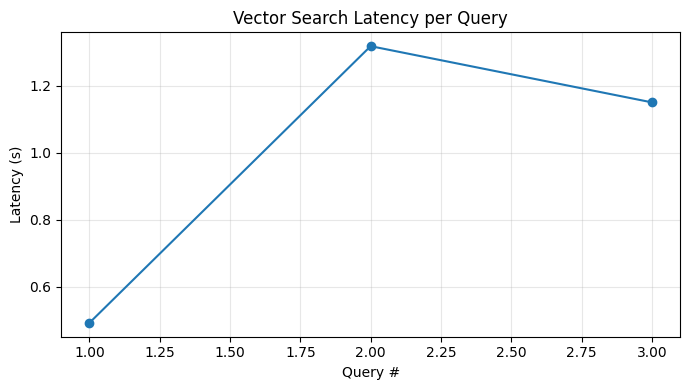

In [7]:
# Metrics: JSONL logging and latency plot
import os
os.makedirs("logs", exist_ok=True)
log_path = "logs/vibe_matcher_metrics.jsonl"
with open(log_path, "w", encoding="utf-8") as f:
    for r in records:
        f.write(json.dumps(r) + "\n")
print(f"\u2713 Logged metrics to {log_path}")

plt.figure(figsize=(7,4))
plt.plot(range(1, len(latencies)+1), latencies, marker="o")
plt.title("Vector Search Latency per Query")
plt.xlabel("Query #")
plt.ylabel("Latency (s)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("vibe_matcher_latency.png", dpi=150)
print("\u2713 Saved latency plot to vibe_matcher_latency.png")


In [8]:
# Reflection: 3–5 bullets and optional txt
reflection = [
    "- Improvements: integrate a vector DB (Pinecone/FAISS) for ANN; re-rank top-10 with a cross-encoder; cache embeddings.",
    "- Edge cases: empty/very short queries trigger fallback; small catalog; ties; multilingual queries (model support varies).",
    "- Metrics: explicit 'good' threshold (>=0.7), JSONL logs; extend with P95 latency and success@k over larger sets.",
    "- Productization: add filters (price/occasion), tracking, and A/B thresholds by intent.",
    "- Ops: switch to 'text-embedding-3-large' for quality-sensitive flows; cost-optimize with caching.",
]
print("Reflection\n" + "\n".join(reflection))

with open("vibe_matcher_reflection.txt", "w", encoding="utf-8") as f:
    f.write("Reflection\n" + "\n".join(reflection))
print("\u2713 Saved reflection to vibe_matcher_reflection.txt")


Reflection
- Improvements: integrate a vector DB (Pinecone/FAISS) for ANN; re-rank top-10 with a cross-encoder; cache embeddings.
- Edge cases: empty/very short queries trigger fallback; small catalog; ties; multilingual queries (model support varies).
- Metrics: explicit 'good' threshold (>=0.7), JSONL logs; extend with P95 latency and success@k over larger sets.
- Productization: add filters (price/occasion), tracking, and A/B thresholds by intent.
- Ops: switch to 'text-embedding-3-large' for quality-sensitive flows; cost-optimize with caching.
✓ Saved reflection to vibe_matcher_reflection.txt
